In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 22 13:25:21 2022

@author: emran
"""


class Guard:
    

    def __init__(self, hardConstraintPenalty):
       
        self.hardConstraintPenalty = hardConstraintPenalty

        # list of guards:
        self.guards = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

       
        self.shiftPreference = [[1, 0, 0], [1, 1, 0], [0, 0, 1], [0, 1, 0], [0, 0, 1], [1, 1, 1], [0, 1, 1], [1, 1, 1]]

        self.shiftMin = [2, 2, 1]
        self.shiftMax = [3, 4, 2]

        # max shifts per week allowed for each guard
        self.maxShiftsPerWeek = 5

        # number of weeks we create a schedule for:
        self.weeks = 1

        # useful values:
        self.shiftPerDay = len(self.shiftMin)
        self.shiftsPerWeek = 7 * self.shiftPerDay

    def __len__(self):
      
        return len(self.guards) * self.shiftsPerWeek * self.weeks


    def getCost(self, schedule):
      
        guardShiftsDict = self.getGuardShifts(schedule)

        
        consecutiveShiftViolations = self.countConsecutiveShiftViolations(guardShiftsDict)
        shiftsPerWeekViolations = self.countShiftsPerWeekViolations(guardShiftsDict)[1]
        guardsPerShiftViolations = self.countGuardsPerShiftViolations(guardShiftsDict)[1]
        shiftPreferenceViolations = self.countShiftPreferenceViolations(guardShiftsDict)

        
        hardContstraintViolations = consecutiveShiftViolations + guardsPerShiftViolations + shiftsPerWeekViolations
        softContstraintViolations = shiftPreferenceViolations

        return self.hardConstraintPenalty * hardContstraintViolations + softContstraintViolations

    def getGuardShifts(self, schedule):
       
        shiftsPerGuard = self.__len__() // len(self.guards)
        guardShiftsDict = {}
        shiftIndex = 0

        for guard in self.guards:
            guardShiftsDict[guard] = schedule[shiftIndex:shiftIndex + shiftsPerGuard]
            shiftIndex += shiftsPerGuard

        return guardShiftsDict

    def countConsecutiveShiftViolations(self, guardShiftsDict):
        
        violations = 0
        # iterate over the shifts of each guard:
        for guardShifts in guardShiftsDict.values():
            # look for two cosecutive '1's:
            for shift1, shift2 in zip(guardShifts, guardShifts[1:]):
                if shift1 == 1 and shift2 == 1:
                    violations += 1
        return violations

    def countShiftsPerWeekViolations(self, guardShiftsDict):
       
        violations = 0
        weeklyShiftsList = []
        # iterate over the shifts of each guard:
        for guardShifts in guardShiftsDict.values():  # all shifts of a single guard
            # iterate over the shifts of each weeks:
            for i in range(0, self.weeks * self.shiftsPerWeek, self.shiftsPerWeek):
                # count all the '1's over the week:
                weeklyShifts = sum(guardShifts[i:i + self.shiftsPerWeek])
                weeklyShiftsList.append(weeklyShifts)
                if weeklyShifts > self.maxShiftsPerWeek:
                    violations += weeklyShifts - self.maxShiftsPerWeek

        return weeklyShiftsList, violations

    def countGuardsPerShiftViolations(self, guardShiftsDict):
        
        totalPerShiftList = [sum(shift) for shift in zip(*guardShiftsDict.values())]

        violations = 0
        # iterate over all shifts and count violations:
        for shiftIndex, numOfGuards in enumerate(totalPerShiftList):
            dailyShiftIndex = shiftIndex % self.shiftPerDay  # -> 0, 1, or 2 for the 3 shifts per day
            if (numOfGuards > self.shiftMax[dailyShiftIndex]):
                violations += numOfGuards - self.shiftMax[dailyShiftIndex]
            elif (numOfGuards < self.shiftMin[dailyShiftIndex]):
                violations += self.shiftMin[dailyShiftIndex] - numOfGuards

        return totalPerShiftList, violations

    def countShiftPreferenceViolations(self, guardShiftsDict):
       
        violations = 0
        for guardIndex, shiftPreference in enumerate(self.shiftPreference):
            # duplicate the shift-preference over the days of the period
            preference = shiftPreference * (self.shiftsPerWeek // self.shiftPerDay)
            # iterate over the shifts and compare to preferences:
            shifts = guardShiftsDict[self.guards[guardIndex]]
            for pref, shift in zip(preference, shifts):
                if pref == 0 and shift == 1:
                    violations += 1

        return violations

    def printScheduleInfo(self, schedule):
       
        guardShiftsDict = self.getGuardShifts(schedule)

        print("Schedule for each guard:")
        for guard in guardShiftsDict:  # all shifts of a single guard
            print(guard, ":", guardShiftsDict[guard])

        print("consecutive shift violations = ", self.countConsecutiveShiftViolations(guardShiftsDict))
        print()

        weeklyShiftsList, violations = self.countShiftsPerWeekViolations(guardShiftsDict)
        print("weekly Shifts = ", weeklyShiftsList)
        print("Shifts Per Week Violations = ", violations)
        print()

        totalPerShiftList, violations = self.countGuardsPerShiftViolations(guardShiftsDict)
        print("Guards Per Shift = ", totalPerShiftList)
        print("Guards Per Shift Violations = ", violations)
        print()

        shiftPreferenceViolations = self.countShiftPreferenceViolations(guardShiftsDict)
        print("Shift Preference Violations = ", shiftPreferenceViolations)
        print()
        
        


In [2]:
from deap import base, tools, creator, algorithms
import random
import matplotlib.pyplot as plt
import numpy as np

In [3]:
## Define general parameters
guards = Guard(10)

pop_size = 100
gens = 100 # iterations
p_cx = 0.9
p_mut = 0.1

#chromosome_len = 100

random.seed(20)


In [4]:
## set up the toolbox
toolbox = base.Toolbox()


creator.create("fitnessMin", base.Fitness, weights=(-1.0,)) # fitness (a class for evaluation)

creator.create("individual", list, fitness=creator.fitnessMin) # a class to represent an individual

## register some functions to the toolbox
toolbox.register("geneCreator", random.randint, 0,1)

toolbox.register("indiCreator", tools.initRepeat, creator.individual, toolbox.geneCreator, len(guards))

toolbox.register("popCreator", tools.initRepeat, list, toolbox.indiCreator)

In [5]:
## define the fitness function
def fitnessFunction(individual):
    #return sum(individual),
    return guards.getCost(individual),

In [6]:
## register genetic operators (select, mate, mutate)
## register the genetic operators (selection, mating/crossover, mutation)
toolbox.register("evaluate", fitnessFunction)
toolbox.register("select", tools.selTournament, tournsize= 2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.01)

gen	nevals	min	avg    
0  	100   	759	1099.26
1  	92    	762	1025.13
2  	90    	661	958.08 
3  	90    	578	881.3  
4  	89    	546	809.98 
5  	89    	455	755.1  
6  	94    	383	681.82 
7  	85    	383	616.07 
8  	82    	353	554.82 
9  	97    	323	512.88 
10 	95    	285	462.98 
11 	87    	285	429.28 
12 	92    	240	388.44 
13 	90    	180	351.15 
14 	92    	205	323.69 
15 	89    	153	301.46 
16 	92    	152	270.81 
17 	89    	157	250.8  
18 	85    	157	227.08 
19 	91    	131	213.34 
20 	91    	131	196.74 
21 	92    	111	182.16 
22 	90    	103	165.37 
23 	91    	89 	153.5  
24 	94    	80 	142.46 
25 	85    	80 	136.31 
26 	95    	78 	126.03 
27 	91    	66 	113.52 
28 	91    	77 	105.07 
29 	95    	70 	101.19 
30 	94    	70 	96.37  
31 	90    	70 	90.32  
32 	96    	61 	85.57  
33 	96    	57 	79.3   
34 	94    	57 	75.84  
35 	90    	57 	73.61  
36 	91    	57 	69.32  
37 	93    	57 	68.47  
38 	89    	56 	65.78  
39 	94    	56 	65.79  
40 	89    	56 	64.03  
41 	90    	47 	60.84  
42 	88    	

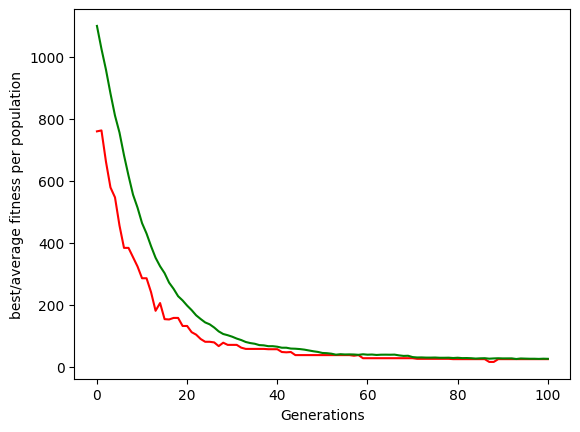

In [7]:
# build and run the algorithm
## build and run the GA
starting_pop = toolbox.popCreator(pop_size)
stats = tools.Statistics(lambda ind:ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)
hof = tools.HallOfFame(5)

final_pop, logbook = algorithms.eaSimple(
    starting_pop,
    toolbox,
    p_cx,
    p_mut,
    gens,
    stats,
    hof,
    True
)

#print(f"best solution: {hof[0]}")

plt.plot(logbook.select("min"), color='red')
plt.plot(logbook.select("avg"), color='green')
plt.xlabel('Generations')
plt.ylabel('best/average fitness per population')
plt.show()


In [8]:
## print the best solution
guards.printScheduleInfo(hof[0])

Schedule for each guard:
A : [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
B : [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
C : [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
D : [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
E : [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
F : [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0]
G : [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
H : [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]
consecutive shift violations =  0

weekly Shifts =  [3, 5, 5, 4, 5, 5, 4, 5]
Shifts Per Week Violations =  0

Guards Per Shift =  [2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2]
Guards Per Shift Violations =  0

Shift Preference Violations =  15

